In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Устройства для вычислений (GPU если доступен)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Нейронная сеть для PINN

In [3]:
class PINNModel(nn.Module):
    def __init__(self, hidden_size=20):
        super(PINNModel, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.layers_stack(x)

## Аналитическое решение для системы с внешней силой cos(ωt)

In [4]:
def analytic_solution(t, omega):
    # Начальные условия x(0) = 0 и dx/dt(0) = 0
    A = 0
    B = 0
    # Общее решение для x(t)
    x_analytic = (1 / (omega**2 - 1)) * torch.cos(omega * t)
    dxdt_analytic = torch.cos(omega * t) * omega / (omega**2 - 1)  # Производная x по t
    d2xdt2_analytic = -omega**2 * torch.cos(omega * t) / (omega**2 - 1)  # Вторая производная x по t
    return x_analytic, dxdt_analytic, d2xdt2_analytic

# Определяем уравнения для разных формулировок

In [5]:
# 1. Для второй формулировки (второй порядок ОДУ)
def pde_second_order(x, t, omega):
    dxdt = torch.autograd.grad(x, t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t, torch.ones_like(t), create_graph=True)[0]
    F = torch.cos(omega * t)  # Внешняя сила
    residual = d2xdt2 + omega**2 * x - F  # Резидуал уравнения
    return residual, dxdt, d2xdt2

# 2. Для первой системы (первый порядок)
def pde_first_order(x, y, t, omega):
    dxdt = y
    dydt = -omega**2 * x + torch.cos(omega * t)
    return dxdt, dydt

# 3. Для альтернативной первой системы
def pde_alternative(x, y, t, omega):
    dxdt = omega * y + (1/omega) * torch.sin(omega * t)
    dydt = -omega * x
    return dxdt, dydt

# Функция потерь для сравнения

In [6]:
def loss_fn(model, t, omega, formulation=1):
    # Получаем решение модели
    if formulation == 1:
        x = model(t)
        res, dxdt, d2xdt2 = pde_second_order(x, t, omega)
        return torch.mean(res**2), x, dxdt, d2xdt2
    elif formulation == 2:
        y = model(t)
        x = y[:, 0:1]
        res1, res2 = pde_first_order(x, y, t, omega)
        return torch.mean(res1**2 + res2**2), x, res1, res2
    elif formulation == 3:
        y = model(t)
        x = y[:, 0:1]
        res1, res2 = pde_alternative(x, y, t, omega)
        return torch.mean(res1**2 + res2**2), x, res1, res2

# Обучение модели

In [7]:
def train_model(formulation, omega, t, epochs=1000, learning_rate=0.001):
    model = PINNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, x, dxdt, d2xdt2 = loss_fn(model, t, omega, formulation)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    
    return model, loss_history, x, dxdt, d2xdt2

In [8]:
# Тестирование модели
def test_model(model, t, omega):
    with torch.no_grad():
        x_pred = model(t)
    return x_pred

# Время и параметры для обучения
t = torch.linspace(0, 10, 1000).reshape(-1, 1).to(device)  # Вектор времени
t.requires_grad = True
omega = 2 * np.pi * 2  # Частота

# Обучаем модели для разных формулировок
model_1, loss_history_1, x_1, dxdt_1, d2xdt2_1 = train_model(1, omega, t)
model_2, loss_history_2, x_2, dxdt_2, d2xdt2_2 = train_model(2, omega, t)
model_3, loss_history_3, x_3, dxdt_3, d2xdt2_3 = train_model(3, omega, t)

# Тестируем модели
x_pred_1 = test_model(model_1, t, omega)
x_pred_2 = test_model(model_2, t, omega)
x_pred_3 = test_model(model_3, t, omega)

# Получаем аналитические решения для x(t), dx/dt(t), d2x/dt2(t)
x_analytic, dxdt_analytic, d2xdt2_analytic = analytic_solution(t, omega)

/home/andredon/Practice3-1/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/1000, Loss: 497.937744140625
Epoch 100/1000, Loss: 0.7462352514266968
Epoch 200/1000, Loss: 0.693228542804718
Epoch 300/1000, Loss: 0.6554616689682007
Epoch 400/1000, Loss: 0.6235877871513367
Epoch 500/1000, Loss: 0.5953591465950012
Epoch 600/1000, Loss: 0.5710282325744629
Epoch 700/1000, Loss: 0.5510316491127014
Epoch 800/1000, Loss: 0.5354000329971313
Epoch 900/1000, Loss: 0.5237835049629211
Epoch 0/1000, Loss: 1099.6978759765625
Epoch 100/1000, Loss: 0.5375623106956482
Epoch 200/1000, Loss: 0.5282998085021973
Epoch 300/1000, Loss: 0.5240182876586914
Epoch 400/1000, Loss: 0.5205671787261963
Epoch 500/1000, Loss: 0.5178289413452148
Epoch 600/1000, Loss: 0.5156070590019226
Epoch 700/1000, Loss: 0.5137148499488831
Epoch 800/1000, Loss: 0.5120314359664917
Epoch 900/1000, Loss: 0.5104982852935791
Epoch 0/1000, Loss: 5.991058826446533
Epoch 100/1000, Loss: 0.006207625847309828
Epoch 200/1000, Loss: 0.00508262449875474
Epoch 300/1000, Loss: 0.004594384226948023
Epoch 400/1000, Loss:

# Визуализация результатов

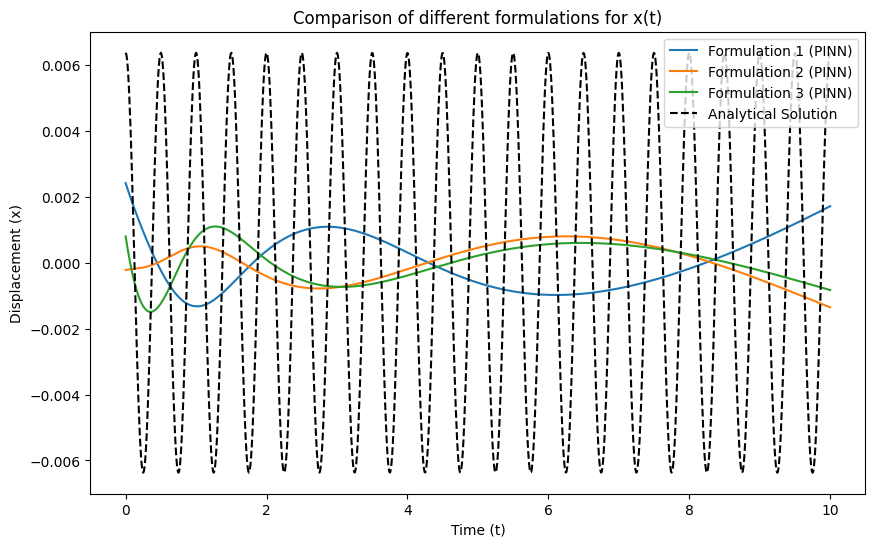

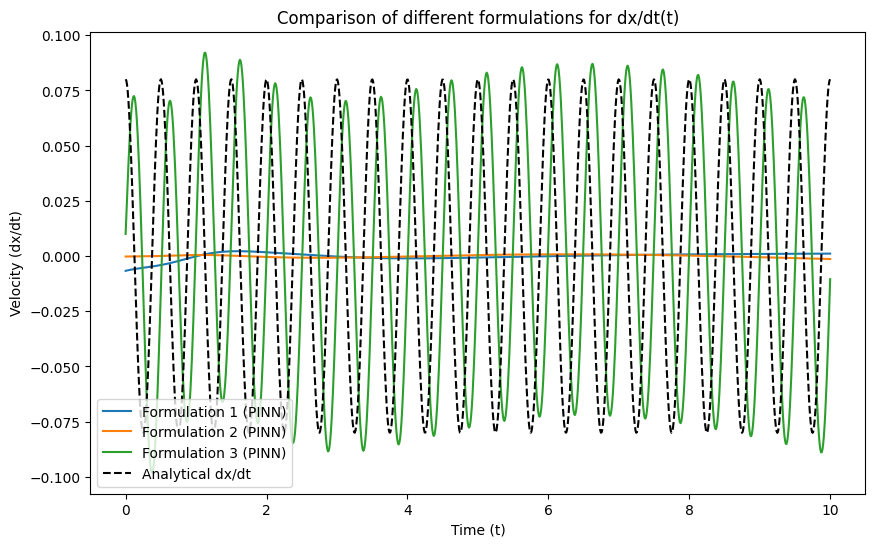

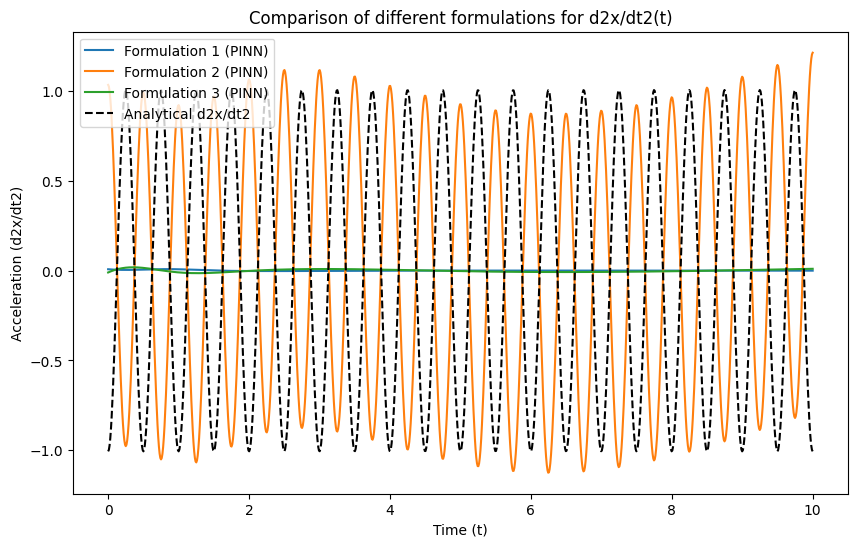

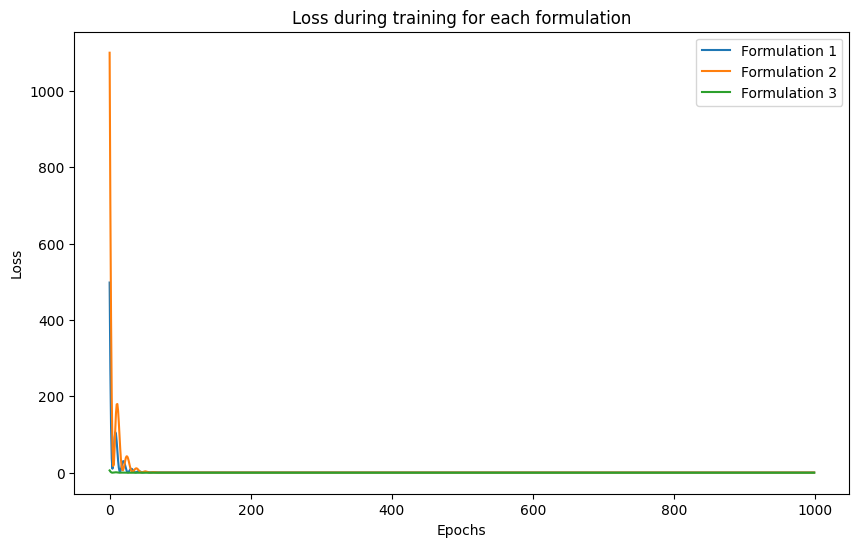

In [9]:
# 1. График x от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), x_pred_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
plt.plot(t.cpu().detach().numpy(), x_pred_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
plt.plot(t.cpu().detach().numpy(), x_pred_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), x_analytic.cpu().detach().numpy(), label='Analytical Solution', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Displacement (x)')
plt.title('Comparison of different formulations for x(t)')
plt.savefig('disp2time_comparison_with_analytic.png')
plt.show()

# 2. Зависимость dx/dt от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), dxdt_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_analytic.cpu().detach().numpy(), label='Analytical dx/dt', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Velocity (dx/dt)')
plt.title('Comparison of different formulations for dx/dt(t)')
plt.savefig('dxdt_comparison_with_analytic.png')
plt.show()

# 3. Зависимость d2x/dt2 от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), d2xdt2_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_analytic.cpu().detach().numpy(), label='Analytical d2x/dt2', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Acceleration (d2x/dt2)')
plt.title('Comparison of different formulations for d2x/dt2(t)')
plt.savefig('d2xdt2_comparison_with_analytic.png')
plt.show()

# 4. График потерь для каждой формулировки
plt.figure(figsize=(10, 6))
plt.plot(loss_history_1, label='Formulation 1')
plt.plot(loss_history_2, label='Formulation 2')
plt.plot(loss_history_3, label='Formulation 3')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training for each formulation')
plt.savefig('loss_comparison.png')
plt.show()
